In [347]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from proteus.matrix import tseries as ts
from proteus.predic import prediction
from proteus.predic import predlib
from proteus.predic import betacluster as bc
from proteus.predic import clustering as hc
from proteus.visu import matrix as visu
#from proteus.predic import fselection as fselect
import pandas as pd
import scipy.io
from os import listdir
import cPickle as pickle

from sklearn.svm import SVC,LinearSVC

from sklearn.model_selection import StratifiedKFold,LeaveOneOut,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import seaborn as sns
sns.set_style("white")

In [154]:
#demograph = pd.read_csv('/media/cdansereau/database1/data/schizo/model_schizo_4studies_psm_20160327.csv', index_col=0)
demograph = pd.read_csv('/media/cdansereau/database1/data/schizo/schizo_6_new_studies_20170516_matched.csv', index_col=0)

#demograph = demograph.sort_index()
demograph.index = demograph.index.map(str.strip)
demograph.columns = demograph.columns.map(str.strip)

mask_sz = np.copy((demograph['sz']==1).values)
strat = np.copy(demograph['study'].values)
strat[mask_sz] += 10
demograph['strat'] = strat

In [104]:
# stack all subjects in one array
def conv_conn4pred(source_path, destination_path):
    root_path = source_path
    list_files = listdir(root_path)
    print('Start loading ' + str(len(list_files)) + ' subjects...')
    R_all = []
    index = []
    for i in range(len(list_files)):
        tmp_mat = scipy.io.loadmat(root_path + list_files[i])
        print(tmp_mat['subj_id'][0])
        if tmp_mat['nframes'][0] > 40:
            R = tmp_mat['R']
            index.append(tmp_mat['subj_id'][0])
            R_all.append(R.T)    
            
    R_all = np.vstack(R_all)            
    print R_all.shape    

    df = pd.DataFrame(R_all, index=index)
    df.to_csv(destination_path + 'model_R_conn_scale064.csv')
conv_conn4pred('/media/cdansereau/database1/data/schizo/schizo_6sites/corrmatrix/','/media/cdansereau/database1/data/schizo/schizo_6sites/connectomes/')

Start loading 382 subjects...
A00036199
CH8043b
SDSZ63
A00036197
sz0040021
SZ50048
SDSZ06
A00036264
HC11066
CH8876b
sz0040059
A00036455
HC11050
SDSZ72
A00036232
A00036366
SZ50034
SZ50050
SDSZ53
SDSZ24
A00036451
A00036409
CH8301a
A00036212
SZ50052
SZ50083
SDSZ68
sz0040133
SZ50067
sz0040109
A00036190
SDSZ26
SZ50023
CH1840
SDSZ52
SDSZ79
sz0040028
sz0040122
A00036351
CH8593b
SDSZ47
sz0040002
CH7930a
HC10746
A00036216
A00036297
A00036241
HC10844
A00036304
SDSZ25
hc0040045
SDSZ77
A00036171
hc0040043
A00036358
CH8402b
CH8701a
SZ50053
hc0040138
HC11030
sz0040064
A00036425
CH8266b
HC11149
SDSZ10
SZ50016
HC10855
A00036256
A00036498
SDSZ102
sz0040080
CH7316a
sz0040103
HC10527
sz0040085
sz0040137
SDSZ81
A00036377
HC11044
A00036201
SZ50035
sz0040145
CH8860b
SDSZ21
A00036214
hc0040014
CH7674b
A00036299
HC10530
SZ50066
SZ50038
HC10871
A00036205
SDSZ56
A00036240
SZ50054
hc0040057
hc0040087
SDSZ95
sz0040034
CH8126b
A00036107
sz0040108
SZ50056
HC11143
SDSZ33
A00036429
SDSZ15
SZ50020
SDSZ73
hc0040023
A00

In [112]:
data = pd.read_csv('/media/cdansereau/database1/data/schizo/schizo_6sites/connectomes/model_R_conn_scale064.csv', index_col=0)

data = data.loc[demograph.index]

In [231]:
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold

def rand_select(mask_site, y, N):
    mask_site = np.copy(mask_site).astype(bool)
    mask_select = np.zeros_like(mask_site).astype(bool)
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=N, random_state=0)
    train_index , test_index = sss.split(y[mask_site,np.newaxis],y[mask_site]).next()
    #print("TRAIN:", train_index)
    idx = np.where(mask_site)[0]
    mask_select[idx[test_index]] = True
    return mask_select
        
rand_select(demograph['study']==1,demograph['sz'].values, 10)

array([ True, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [80]:
from itertools import combinations

# compute the site id combinations for training and testing
def get_sites(n_sites=6, comb_set=2, intra=True):
    
    L = np.arange(1,n_sites+1)
    train_combi = np.array([ comb for comb in combinations(L, comb_set)])
    
    
    if intra:
        test_combi = np.copy(train_combi)
    else:
        test_combi = np.array([[x for x in L if x not in train_combi[ii]] for ii in range(train_combi.shape[0])])
    
    return train_combi,test_combi
    
get_sites(n_sites=6,comb_set=4,intra=False)

(array([[1, 2, 3, 4],
        [1, 2, 3, 5],
        [1, 2, 3, 6],
        [1, 2, 4, 5],
        [1, 2, 4, 6],
        [1, 2, 5, 6],
        [1, 3, 4, 5],
        [1, 3, 4, 6],
        [1, 3, 5, 6],
        [1, 4, 5, 6],
        [2, 3, 4, 5],
        [2, 3, 4, 6],
        [2, 3, 5, 6],
        [2, 4, 5, 6],
        [3, 4, 5, 6]]), array([[5, 6],
        [4, 6],
        [4, 5],
        [3, 6],
        [3, 5],
        [3, 4],
        [2, 6],
        [2, 5],
        [2, 4],
        [2, 3],
        [1, 6],
        [1, 5],
        [1, 4],
        [1, 3],
        [1, 2]]))

In [682]:
train_sites,test_sites = get_sites(n_sites=6,comb_set=2,intra=False)
print train_sites,test_sites

def grab_data(X, demog, site_list, select=False, n_select=[32,21,16,13]):
    #
    x = []
    y = []
    strat_id = []
    sites_id = []
    confounds = []
    #
    for ii in site_list:
        if select:
            mask = rand_select((demog['study']==ii).values,demog['sz'].values, n_select[site_list.shape[0]-2])
            
        else:
            mask = np.array((demog['study']==ii).values)
            
        x.append(X[mask])
        y.append(demog[mask]['sz'].values)
        strat_id.append(demog[mask]['strat'].values)
        sites_id.append(demog[mask]['study'].values)
        confounds.append(demog[mask][['age','sex','rFD1']].values)
            
    return np.vstack(x), np.hstack(y), np.hstack(strat_id), np.hstack(sites_id), np.vstack(confounds)

x_,y_,strat_,sites_id_ , conf_= grab_data(data,demograph,train_sites[3], select=True)

print x_.shape,y_.shape,strat_.shape

[[1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [2 3]
 [2 4]
 [2 5]
 [2 6]
 [3 4]
 [3 5]
 [3 6]
 [4 5]
 [4 6]
 [5 6]] [[3 4 5 6]
 [2 4 5 6]
 [2 3 5 6]
 [2 3 4 6]
 [2 3 4 5]
 [1 4 5 6]
 [1 3 5 6]
 [1 3 4 6]
 [1 3 4 5]
 [1 2 5 6]
 [1 2 4 6]
 [1 2 4 5]
 [1 2 3 6]
 [1 2 3 5]
 [1 2 3 4]]
(64, 2016) (64,) (64,)


In [503]:
train_sites,test_sites = get_sites(n_sites=6,comb_set=1,intra=False)

train_sites,test_sites

(array([[1],
        [2],
        [3],
        [4],
        [5],
        [6]]), array([[2, 3, 4, 5, 6],
        [1, 3, 4, 5, 6],
        [1, 2, 4, 5, 6],
        [1, 2, 3, 5, 6],
        [1, 2, 3, 4, 6],
        [1, 2, 3, 4, 5]]))

In [688]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score, precision_score

select = False
scores = []
all_stats = []
for intra in [True, False]:
    print ''
    for comb_set in np.arange(1,6):
        #parameters = {'C':[0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08]}
        parameters = {'C':[0.001, 0.005, 0.01, 0.05]}
        #parameters = {'C':[1,0.01, 0.05,0.1]}
        train_sites,test_sites = get_sites(n_sites=6,comb_set=comb_set,intra=intra)
        comb_results = []
        for ii in range(train_sites.shape[0]):

            ## CV ##
            y_pred = []
            y_ref = []
            site_id = []

            if intra:
                x_,y_,strat_,sites_id_,conf_ = grab_data(data,demograph,train_sites[ii], select=select)
                
                skf = StratifiedKFold(n_splits=10)
                for train_index, test_index in skf.split(x_,strat_):
                    mean_ = x_[train_index].mean(0)
                    std_  = x_[train_index].std(0)
                    x_dm = (x_ - mean_) / std_
                    crm = prediction.ConfoundsRm(conf_[train_index],x_dm[train_index])
                    x_dm = crm.transform(conf_,x_dm)
                    

                    #clf = SVC(kernel='linear',class_weight='balanced',C=0.02)
                    #clf = LogisticRegression(class_weight='balanced',C=1).fit(x_[train_index],y_[train_index])
                    #clf = LinearSVC(dual=False,penalty='l1',class_weight='balanced',C=0.005)
                    clf = LinearSVC(class_weight='balanced',C=0.005)

                    gs = GridSearchCV(clf, parameters).fit(x_dm[train_index],y_[train_index])

                    ### TEST ###
                    y_pred.append(gs.predict(x_dm[test_index]))
                    y_ref.append(y_[test_index])
                    site_id.append(sites_id_[test_index])

            else:
                x_,y_,strat_,sites_id_,conf_ = grab_data(data,demograph,train_sites[ii], select=select)
                mean_ = x_.mean(0)
                std_  = x_.std(0)
                x_dm = (x_ - mean_) / std_
                crm = prediction.ConfoundsRm(conf_,x_dm)
                x_dm = crm.transform(conf_,x_dm)
                #clf = SVC(kernel='linear',class_weight='balanced',C=0.02)
                #clf = LinearSVC(dual=False,penalty='l1',class_weight='balanced',C=0.005)
                clf = LinearSVC(class_weight='balanced',C=0.005)
                gs = GridSearchCV(clf, parameters).fit(x_dm,y_)
                
                ### TEST ###
                x_,y_,strat_,sites_id_,conf_ = grab_data(data,demograph,test_sites[ii], select=select)
                x_dm = (x_ - mean_) / std_
                x_dm = crm.transform(conf_,x_dm)
                y_pred.append(gs.predict(x_dm))
                y_ref.append(y_)
                site_id.append(sites_id_)
            # nsites_train
            label_nsites_train = np.ones_like(np.hstack(y_ref))*comb_set
            label_intra = np.ones_like(label_nsites_train)*int(intra)
            id_train = int(''.join([str(a) for a in train_sites[ii]]))
            label_idtrain = [id_train for a in range(len(label_intra))]
            label_idtest = np.hstack(site_id)
            label_hm = (np.hstack(y_ref) == np.hstack(y_pred)).astype(int)
            comb_results.append(np.vstack((label_nsites_train,label_intra,label_idtrain,label_idtest,label_hm,np.hstack(y_ref),np.hstack(y_pred))).T)
        comb_results = np.vstack(comb_results)  
        all_stats.append(comb_results)

        scores.append([accuracy_score(comb_results[:,-2],comb_results[:,-1]),recall_score(comb_results[:,-2],comb_results[:,-1]),precision_score(comb_results[:,-2],comb_results[:,-1])])
        print scores[-1]
        
scores = np.array(scores)




[0.64921465968586389, 0.5759162303664922, 0.67484662576687116]
[0.64031413612565447, 0.5759162303664922, 0.66105769230769229]
[0.65157068062827228, 0.59842931937172772, 0.66959578207381376]
[0.66230366492146597, 0.60837696335078539, 0.681924882629108]
[0.67748691099476444, 0.63350785340314131, 0.69460390355912749]

[0.56806282722513091, 0.52251308900523563, 0.57488479262672809]
[0.59109947643979055, 0.54764397905759166, 0.59977064220183485]
[0.61361256544502618, 0.56387434554973825, 0.62616279069767444]
[0.6465968586387435, 0.58324607329842937, 0.66786570743405271]
[0.66230366492146597, 0.5706806282722513, 0.69871794871794868]


In [678]:
scores

array([[ 0.64921466,  0.58638743,  0.67065868],
       [ 0.63874346,  0.56230366,  0.66378245],
       [ 0.65052356,  0.55706806,  0.68512556],
       [ 0.6552356 ,  0.57068063,  0.6868305 ],
       [ 0.66596859,  0.58534031,  0.69787765],
       [ 0.57748691,  0.51727749,  0.58809524],
       [ 0.61125654,  0.53717277,  0.63060848],
       [ 0.62434555,  0.53507853,  0.6513703 ],
       [ 0.6460733 ,  0.56963351,  0.67243511],
       [ 0.68586387,  0.59685864,  0.72611465]])

In [693]:
df = pd.DataFrame(np.vstack(all_stats),columns=['nsites_train','intra','idtrain','idtest','hm','y_ref','y_pred'])
df = df.sort_values(['idtest', 'idtrain', 'nsites_train', 'intra'], ascending=[1, 1, 1, 0])

site_size = []
site_size.append(df[(df['idtest']==1) & (df['intra']==1) ].shape[0])
site_size.append(df[(df['idtest']==2) & (df['intra']==1) ].shape[0])
site_size.append(df[(df['idtest']==3) & (df['intra']==1) ].shape[0])
site_size.append(df[(df['idtest']==4) & (df['intra']==1) ].shape[0])
site_size.append(df[(df['idtest']==5) & (df['intra']==1) ].shape[0])
site_size.append(df[(df['idtest']==6) & (df['intra']==1) ].shape[0])
site_size = np.array(site_size).astype(float)
print 'sites size',site_size
weight_ratio = site_size.sum()/(6*site_size)

print 'Weight ratio',weight_ratio

# Assigne the w to each entry
for ii in range(len(site_size)):
    df.loc[(df['idtest']==ii+1),'weights']=weight_ratio[ii]

df = df.reset_index()
del df['index']  

#df.to_csv('/home/cdansereau/data/schizo/schizo_6sites/summary_results_r1_3foldcv.csv')
#df.to_csv('/home/cdansereau/data/schizo/schizo_6sites/summary_results_r1_5foldcv.csv')
df.to_csv('/home/cdansereau/data/schizo/schizo_6sites/summary_results_r1_conf_10foldcv.csv')

sites size [ 2604.  2542.  1922.  1550.  1054.  2170.]
Weight ratio [ 0.75793651  0.77642276  1.02688172  1.27333333  1.87254902  0.90952381]


In [656]:
df

,nsites_train,intra,idtrain,idtest,hm,y_ref,y_pred,weights
0,1,1,1,1,1,0,0,0.757937
1,1,1,1,1,1,0,0,0.757937
2,1,1,1,1,1,0,0,0.757937
3,1,1,1,1,0,0,1,0.757937
4,1,1,1,1,1,0,0,0.757937
5,1,1,1,1,0,0,1,0.757937
6,1,1,1,1,1,0,0,0.757937
7,1,1,1,1,1,0,0,0.757937
8,1,1,1,1,1,0,0,0.757937
9,1,1,1,1,1,0,0,0.757937


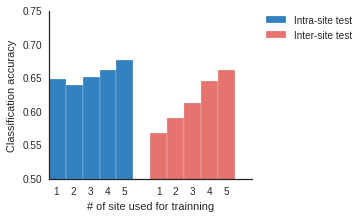

In [691]:
def plot_bars(stats,yaxis_label='Classification accuracy',vmin=0.5,vmax=0.75):
#import seaborn as sns
#sns.set_context("poster")#talk
    

    plt.figure(figsize=(8, 3))
    new_style = {'grid': False}
    plt.rc('axes', **new_style)
    n_groups = 2
    
    means_intra = stats[:5,0]
    #std_intra = (0, 0, 0, 0)

    means_inter = stats[5:10,0]
    #std_inter = (0, 0, 0, 0)

    #fig, ax = plt.subplots()
    ax = plt.subplot(1,2,1)
    bar_width = 0.25
    opacity = 0.8
    error_config = {'ecolor': '0.3'}

    index = np.arange(0,1.25,bar_width)
    rects1 = plt.bar(index, means_intra, bar_width,
                     alpha=opacity,
                     color='#0062af',
                     edgecolor='#ffffff',
                     #yerr=std_intra,
                     #error_kw=error_config,
                     label='Intra-site test')

    index = np.arange(1.25,2.5,bar_width)
    rects2 = plt.bar(index + bar_width, means_inter, bar_width,
                     alpha=opacity,
                     color='#e0504a',#'#fdcc61',
                     edgecolor='#ffffff',
                     hatch="",
                     #yerr=std_inter,
                     #error_kw=error_config,
                     label='Inter-site test')


    plt.xlabel('# of site used for trainning')
    plt.ylabel(yaxis_label)
    #plt.title('Site regression')
    #plt.xticks(index + bar_width + bar_width/2., ('Intra-site test', 'Inter-site test'))
    plt.xticks(np.hstack([np.arange(0.25/2.25,1.25,bar_width),np.arange(1.5+.25/2.,2.75,bar_width)]), ('1','2','3','4','5','1','2','3','4','5'))

    #plt.legend()
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    plt.ylim((vmin,vmax))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')


    #plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    

    #plt.tight_layout()
    #plt.show()
    
plot_bars(scores)
plt.savefig('figures/samples/scores_select0_acc.png', dpi = 300, bbox_inches='tight')

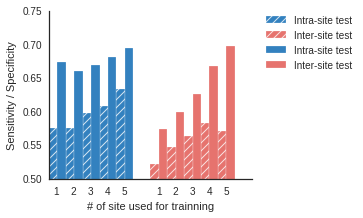

In [692]:
def plot_bars_sens_spec(stats,yaxis_label=['Classification accuracy'],vmin=0.5,vmax=0.75):
#import seaborn as sns
#sns.set_context("poster")#talk
    n_sub_var = stats.shape[1]

    plt.figure(figsize=(8, 3))
    new_style = {'grid': False}
    plt.rc('axes', **new_style)
    n_groups = 2
    for ii in np.arange(1,n_sub_var):
        means_intra = stats[:5,ii]
        

        means_inter = stats[5:10,ii]
        

        #fig, ax = plt.subplots()
        ax = plt.subplot(1,2,1)
        bar_width = 0.25
        opacity = 0.8
        error_config = {'ecolor': '0.3'}

        if ii == 1:
            hatch = '///'
        else:
            hatch =''
            
        index = np.arange(0,1.25,bar_width)+(ii-1)*bar_width/2
        rects1 = plt.bar(index, means_intra, bar_width/2,
                         alpha=opacity,
                         color='#0062af',
                         edgecolor='#ffffff',
                         hatch=hatch,
                         #yerr=std_intra,
                         #error_kw=error_config,
                         label='Intra-site test')

        index = np.arange(1.25,2.5,bar_width)+(ii-1)*bar_width/2
        rects2 = plt.bar(index + bar_width, means_inter, bar_width/2,
                         alpha=opacity,
                         color='#e0504a',#'#fdaa61',
                         edgecolor='#ffffff',
                         hatch=hatch,
                         #yerr=std_inter,
                         #error_kw=error_config,
                         label='Inter-site test')


    plt.xlabel('# of site used for trainning')
    plt.ylabel('Sensitivity / Specificity')
    #plt.title('Site regression')
    #plt.xticks(index + bar_width + bar_width/2., ('Intra-site test', 'Inter-site test'))
    plt.xticks(np.hstack([np.arange(0.25/2.25,1.25,bar_width),np.arange(1.5+.25/2.,2.75,bar_width)]), ('1','2','3','4','5','1','2','3','4','5'))
    
    #plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    plt.ylim((vmin,vmax))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    #plt.tight_layout()
    #plt.show()
    
plot_bars_sens_spec(scores)
plt.savefig('figures/samples/scores_select0_ss.png', dpi = 300, bbox_inches='tight')

## predict site label

In [710]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score, precision_score

regress_site_flag = True
select = False
scores = []
all_stats = []
for intra in [True]:
    print ''
    for comb_set in [2]:
        #parameters = {'C':[0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08]}
        parameters = {'C':[0.001, 0.005, 0.01, 0.05]}
        #parameters = {'C':[1,0.01, 0.05,0.1]}
        train_sites,test_sites = get_sites(n_sites=6,comb_set=comb_set,intra=intra)
        comb_results = []
        for ii in range(train_sites.shape[0]):

            ## CV ##
            y_pred = []
            y_ref = []
            site_id = []

            if intra:
                x_,y_,strat_,sites_id_,conf_ = grab_data(data,demograph,train_sites[ii], select=select)
                
                skf = StratifiedKFold(n_splits=3)
                for train_index, test_index in skf.split(x_,strat_):
                    mean_ = x_[train_index].mean(0)
                    std_  = x_[train_index].std(0)
                    x_dm = (x_ - mean_) / std_
                    if regress_site_flag:
                        conf_ = np.hstack((conf_,sites_id_[:,np.newaxis]))
                    crm = prediction.ConfoundsRm(conf_[train_index],x_dm[train_index])
                    x_dm = crm.transform(conf_,x_dm)
                    

                    #clf = SVC(kernel='linear',class_weight='balanced',C=0.02)
                    #clf = LogisticRegression(class_weight='balanced',C=1).fit(x_[train_index],y_[train_index])
                    #clf = LinearSVC(dual=False,penalty='l1',class_weight='balanced',C=0.005)
                    clf = LinearSVC(class_weight='balanced',C=0.005)

                    gs = GridSearchCV(clf, parameters).fit(x_dm[train_index],sites_id_[train_index])

                    ### TEST ###
                    y_pred.append(gs.predict(x_dm[test_index]))
                    y_ref.append(sites_id_[test_index])
                    site_id.append(sites_id_[test_index])

            else:
                x_,y_,strat_,sites_id_,conf_ = grab_data(data,demograph,train_sites[ii], select=select)
                mean_ = x_.mean(0)
                std_  = x_.std(0)
                x_dm = (x_ - mean_) / std_
                crm = prediction.ConfoundsRm(conf_,x_dm)
                x_dm = crm.transform(conf_,x_dm)
                #clf = SVC(kernel='linear',class_weight='balanced',C=0.02)
                #clf = LinearSVC(dual=False,penalty='l1',class_weight='balanced',C=0.005)
                clf = LinearSVC(class_weight='balanced',C=0.005)
                gs = GridSearchCV(clf, parameters).fit(x_dm,y_)
                
                ### TEST ###
                x_,y_,strat_,sites_id_,conf_ = grab_data(data,demograph,test_sites[ii], select=select)
                x_dm = (x_ - mean_) / std_
                x_dm = crm.transform(conf_,x_dm)
                y_pred.append(gs.predict(x_dm))
                y_ref.append(y_)
                site_id.append(sites_id_)
            # nsites_train
            label_nsites_train = np.ones_like(np.hstack(y_ref))*comb_set
            label_intra = np.ones_like(label_nsites_train)*int(intra)
            id_train = int(''.join([str(a) for a in train_sites[ii]]))
            label_idtrain = [id_train for a in range(len(label_intra))]
            label_idtest = np.hstack(site_id)
            label_hm = (np.hstack(y_ref) == np.hstack(y_pred)).astype(int)
            comb_results.append(np.vstack((label_nsites_train,label_intra,label_idtrain,label_idtest,label_hm,np.hstack(y_ref),np.hstack(y_pred))).T)
        comb_results = np.vstack(comb_results)  
        all_stats.append(comb_results)

        
        



In [709]:
# with site regression
(comb_results[:,-2]==comb_results[:,-1]).mean()

0.63717277486910995

In [702]:
# no site regression
(comb_results[:,-2]==comb_results[:,-1]).mean()

0.84397905759162306